#導入Tensorflow 2.0

In [0]:
!pip install tensorflow==2.0.0-beta > /dev/null 2>&1

#導入Box.2D相關套件

In [2]:
pip install -i https://pypi.tuna.tsinghua.edu.cn/simple box2d-py

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
!apt-get install xvfb
!pip install pyvirtualdisplay
!pip install Pillow
!pip install 'gym[box2d]'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

#導入相關函式庫

In [5]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow.compat.v2 as tf
import random
import numpy as np
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

#Import Video

In [0]:
import glob
from gym.wrappers import Monitor
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#Main_採用隨機動作

In [0]:
import gym
import time
from IPython import display
from PIL import Image

env = wrap_env(gym.make('LunarLanderContinuous-v2'))
env.reset()

for episode in range(1):
  observation = env.reset()  
  for i in range(1000): 
    action = env.action_space.sample()   # 从 action_space 随机采样一个动作
    observation, reward, done, info = env.step(action)   # 执行动作
    #print(f'Action {action} Reward {reward}')
            
    
    
    if done:
        break
        
env.close()

#Video_採用隨機動作

In [8]:
show_video()

  GPUid: r
  Model: SN_DDPG_r
| Remove
        env_name	imeLimit<LunarLanderContinuous<LunarLanderContinuous-v2>>>
       state_dim	8
      action_dim	2
      action_max	(1.0, 'Continuous')
   target_reward	200
Loading: SN_DDPG_r
FileNotFound in mod_dir:SN_DDPG_r
FileNotFound: SN_DDPG_r/memories.npy
   2    eva_reward -633.21    epoch_reward -349.51    actor_loss   0.63    critic_loss   1.75
   4    eva_reward -498.80    epoch_reward -344.05    actor_loss   2.49    critic_loss   1.79
   5    eva_reward -431.91    epoch_reward -312.87    actor_loss  -1.73    critic_loss   1.35
   6    eva_reward -396.15    epoch_reward -282.32    actor_loss  -7.47    critic_loss   0.99
   7    eva_reward -354.27    epoch_reward -269.53    actor_loss -14.01    critic_loss   0.89
   8    eva_reward -235.76    epoch_reward -257.73    actor_loss -17.81    critic_loss   0.76
   9    eva_reward -200.17    epoch_reward -174.80    actor_loss -23.65    critic_loss   0.78
  10    eva_reward -150.94    epoch_rewar

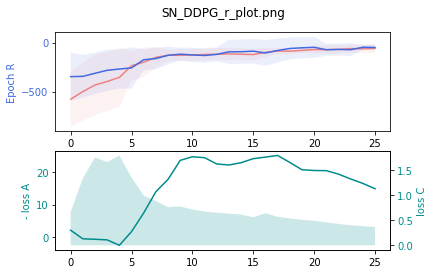

In [0]:
import os
import sys
from time import time as timer

import gym
import numpy as np
import numpy.random as rd
# from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F

# import torch.utils.data as data

"""
2019-07-01 Zen4Jia1Hao2, GitHub: Yonv1943
2019-08-01 Delay DDPG
2019-10-10 spectral normalization (should not use soft_update with SN)
2019-11-12 spectral normalization (should not use batch normalization with SN)
2019_11_22 essay-0.0 yi4shi2
2019_12_12 get_eva_reward_batch
"""


class Arguments:
    env_name = "LunarLanderContinuous-v2"
    max_step = 2000  # max steps in one epoch
    max_epoch = 1000  # max num of train_epoch

    '''device'''
    gpu_id = sys.argv[0][-4]
    mod_dir = 'SN_DDPG_%s' % gpu_id
    is_remove = True  # remove the pre-training data? (True, False, None:ask me)
    random_seed = 1943

    '''training'''
    actor_dim = 2 ** 8  # the network width of actor_net
    critic_dim = int(actor_dim * 1.25)  # the network width of critic_net
    memories_size = int(2 ** 16)  # memories capacity (memories: replay buffer)
    batch_size = 2 ** 8  # num of transitions sampled from replay buffer.

    update_gap = 2 ** 7  # update the target_net, delay update
    update_c = 2  # update times of A:C is update_a:update_c, update_a==1

    gamma = 0.99  # discount factor of future rewards
    explore_noise = 0.3  # action = select_action(state) + noise, 'explore_noise': sigma of noise
    policy_noise = 0.6  # actor_target(next_state) + noise,  'policy_noise': sigma of noise

    def __init__(self):
        # 1397s 77e, 2423s 69e, 1691s 57e, 1228s 51e
        # 30000~40000t 50~70e
        self.env_name = "LunarLanderContinuous-v2"
        self.explore_noise = 0.3
        self.policy_noise = 0.6

        # 1784s 93, 1580s 95e, 1978s 120e
        # 50000~65000t 120~140e
        # self.env_name = "BipedalWalker-v2"
        # self.explore_noise = 0.4
        # self.policy_noise = 0.8


def run_train():  # 2019-12-11 2044
    args = Arguments()

    """initialization"""
    gpu_id = args.gpu_id
    mod_dir = args.mod_dir
    actor_dim = args.actor_dim
    critic_dim = args.critic_dim
    memories_size = args.memories_size
    random_seed = args.random_seed
    is_remove = args.is_remove
    env_name = args.env_name

    print('  GPUid: %s' % gpu_id)
    print('  Model: %s' % mod_dir)
    whether_remove_history(remove=is_remove, mod_dir=mod_dir)

    '''init env'''
    env = wrap_env(gym.make('LunarLanderContinuous-v2'))
    env.reset()
    state_dim, action_dim, action_max, target_reward = get_env_info(env)
    eva_size = 100

    '''init mod'''
    os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)
    agent = AgentDelayDDPG(state_dim, action_dim, actor_dim, critic_dim)
    agent.load_model(mod_dir)

    memories = Memories(memories_size, state_dim, action_dim)
    memories.load(mod_dir)

    torch.set_num_threads(8)
    torch.set_default_dtype(torch.float32)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    """train loop"""
    max_epoch = args.max_epoch
    max_step = args.max_step
    explore_noise = args.explore_noise
    policy_noise = args.policy_noise
    batch_size = args.batch_size
    update_gap = args.update_gap
    update_c = args.update_c
    gamma = args.gamma

    '''show and plot'''
    show_gap = 2 ** 5  # print the Reward, actor_loss, critic_loss
    smooth_kernel = 2 ** 3  # smooth the reward/loss curves
    recorders = list()  # recorders.append((eva_reward, epoch_reward, actor_loss, critic_loss))
    recorders1 = list()  # recorders1.append((eva_reward, eva_std, iter_num))
    env_list = [gym.make(env_name) for _ in range(eva_size)]
    global_iter_num = 0

    start_time = show_time = timer()
    try:
        for epoch in range(max_epoch):
            epoch_reward, iter_num = agent.inactive_in_env(
                env, memories, max_step, explore_noise, action_max, )

            actor_loss, critic_loss = agent.update_parameter(
                memories, iter_num, batch_size, policy_noise, update_gap, update_c, gamma, )

            eva_reward = get_eva_reward(
                agent, env, max_step, action_max, target_reward, )

            recorders.append((eva_reward, epoch_reward, actor_loss, critic_loss))
            global_iter_num += iter_num

            if timer() - show_time > show_gap:
                rewards = np.array(recorders[-smooth_kernel:])[:, 0:2]
                smooth_eva_r, smooth_epoch_r = np.average(rewards, axis=0)
                print("{:4}F    eva_reward {:7.2f}    epoch_reward {:7.2f}    actor_loss {:6.2f}    critic_loss {:6.2f}".format(
                    epoch, smooth_eva_r, smooth_epoch_r, actor_loss, critic_loss))

                eva_reward, eva_std = get_eva_reward_batch(
                    agent, env_list, max_step, action_max)

                recorders1.append((eva_reward, eva_std, global_iter_num, epoch))
                show_time = timer()  # reset show_time after get_eva_reward_batch !

            if eva_reward >= target_reward:
                print("########## Solved! ###########")
                print("{:4}    |EvaR {:7.2f}    |EpoR {:7.2f}    |A {:6.2f}    C {:6.2f}".format(
                    epoch, eva_reward, epoch_reward, actor_loss, critic_loss))
                break

    except KeyboardInterrupt:
        print("KeyboardInterrupt")
    print('TimeUsed:', int(timer() - start_time))
    agent.save_model(mod_dir)
    memories.save(mod_dir)
    np.save('%s/recorders.npy' % mod_dir, recorders)
    np.save('%s/recorders1.npy' % mod_dir, recorders1)
    print("Saved:", mod_dir)

    draw_plot(recorders, mod_dir, smooth_kernel)


def run_eval():  # 2019-12-11
    args = Arguments()

    """initialization"""
    gpu_id = args.gpu_id
    mod_dir = args.mod_dir
    env_name = args.env_name
    max_step = args.max_step
    actor_dim = args.actor_dim

    '''init env'''
    env = wrap_env(gym.make('LunarLanderContinuous-v2'))
    env.reset()
    state_dim, action_dim, action_max, target_reward = get_env_info(env)

    '''init mod'''
    os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    act = Actor(state_dim, action_dim, actor_dim, device).to(device)
    act.load_state_dict(torch.load('%s/actor.pth' % (mod_dir,), map_location=lambda storage, loc: storage))
    act.eval()

    """eval loop"""
    eval_epoch = 4  # reload and evaluate the target policy network(actor)

    # import cv2
    t0 = timer()
    for epoch in range(eval_epoch):
        epoch_reward = 0
        state = env.reset()
        for iter_num in range(max_step):
            '''select_action'''
            state = torch.tensor((state,), dtype=torch.float32, device=device)
            action = act(state).cpu().data.numpy()[0]

            state, reward, done, _ = env.step(action * action_max)
            epoch_reward += reward

            env.render()
            # cv2.imwrite('%s/img_%4i.png'%(mod_dir, iter_num), env.render(mode='rgb_array'))

            if done:
                break

        print("%3i\tEpiR %3i" % (epoch, epoch_reward))
    env.close()
    print(int(timer() - t0))


def run_test():  # 2019-12-12
    args = Arguments()
    mod_dir = args.mod_dir

    load_path = '%s/recorders1.npy' % mod_dir
    recorders1 = np.load(load_path)
    print(recorders1.shape)

    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1)

    '''sum_iter_nums'''
    # iter_nums = recorders1[:, 2]
    # sum_iter_nums = [iter_nums[0], ]
    # for iter_num in iter_nums[1:]:
    #     sum_iter_nums.append(sum_iter_nums[-1] + iter_num)
    sum_iter_nums = recorders1[:, 2]

    rs_avg = recorders1[:, 0]
    rs_std_2 = recorders1[:, 1] / 2.0
    ax_color = 'royalblue'
    ax_label = 'Epoch R'
    axs.plot(sum_iter_nums, rs_avg, label=ax_label, color=ax_color)
    axs.fill_between(sum_iter_nums, rs_avg - rs_std_2, rs_avg + rs_std_2,
                     facecolor=ax_color, alpha=0.2, )

    plt.savefig('{}/gloabal_iter_num.png'.format(mod_dir))
    plt.ion()
    plt.pause(4)
    # plt.show()


'''Network'''


class AgentDelayDDPG:
    def __init__(self, state_dim, action_dim, actor_dim, critic_dim):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        '''dim and idx'''
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.state_idx = 1 + 1 + state_dim  # reward_dim==1, done_dim==1, state_dim
        self.action_idx = self.state_idx + action_dim

        '''actor'''
        act = Actor(state_dim, action_dim, actor_dim, device).to(device)
        act.train()
        self.act = act
        self.act_optimizer = torch.optim.Adam(act.parameters(), lr=8e-4, betas=(0.5, 0.99))

        act_target = Actor(state_dim, action_dim, actor_dim, device).to(device)
        act_target.eval()
        self.act_target = act_target
        self.act_target.load_state_dict(act.state_dict())

        '''critic'''
        cri = Critic(state_dim, action_dim, critic_dim).to(device)
        cri.train()
        self.cri = cri
        self.cri_optimizer = torch.optim.Adam(cri.parameters(), lr=8e-4, betas=(0.5, 0.99))

        cri_target = Critic(state_dim, action_dim, critic_dim).to(device)
        cri_target.eval()
        self.cri_target = cri_target
        self.cri_target.load_state_dict(cri.state_dict())

        self.criterion = nn.SmoothL1Loss()

        self.cri_update_counter = 0
        self.act_update_counter = 0
        self.actor_loss_avg = 0.0
        self.critic_loss_avg = 1.0

    def select_action(self, state, explore_noise=0.0):
        state = torch.tensor((state,), dtype=torch.float32, device=self.device)
        action = self.act(state, explore_noise).cpu().data.numpy()
        return action[0]

    @staticmethod
    def soft_update(target, source, tau=0.01):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    def inactive_in_env(self, env, memories, max_step, explore_noise, action_max):
        state = env.reset()

        epoch_reward = 0
        iter_num = 0

        self.act.eval()
        for iter_num in range(max_step):
            action = self.select_action(state, explore_noise)

            next_state, reward, done, _ = env.step(action * action_max)
            memories.add(np.hstack((reward, 1 - float(done), state, action, next_state)))
            state = next_state

            epoch_reward += reward

            if done:
                break
        return epoch_reward, iter_num

    def update_parameter(self, memories, iter_num, batch_size, policy_noise, update_gap,
                         update_c, gamma):  # 2019-12-11
        self.act_optimizer.param_groups[0]['lr'] = \
            np.exp(-(self.critic_loss_avg / 4.0) ** 2) * 4e-4
        self.actor_loss_avg = self.critic_loss_avg = 0

        k = 1 + memories.size / memories.memo_size
        iter_num = int(iter_num * k)
        batch_size = int(batch_size * k)

        for i_act in range(iter_num):
            for i_cri in range(update_c):
                with torch.no_grad():
                    memory = memories.sample(batch_size)
                    memory = torch.tensor(memory, dtype=torch.float32, device=self.device)

                    reward = memory[:, 0:1]
                    undone = memory[:, 1:2]
                    state = memory[:, 2:self.state_idx]
                    action = memory[:, self.state_idx:self.action_idx]
                    next_state = memory[:, self.action_idx:]
                    next_action = self.act_target(next_state, policy_noise)

                    q_target = self.cri_target(next_state, next_action)
                    q_target = reward + undone * gamma * q_target

                self.cri.train()
                q_eval = self.cri(state, action)
                critic_loss = self.criterion(q_eval, q_target)
                self.critic_loss_avg += critic_loss.item()
                self.cri_optimizer.zero_grad()
                critic_loss.backward()
                self.cri_optimizer.step()

                self.cri_update_counter += 1
                if self.cri_update_counter == update_gap:
                    self.cri_update_counter = 0

                    self.cri_target.load_state_dict(self.cri.state_dict())
                    # self.soft_update(self.cri_target, self.cri, tau=0.5)

            self.cri.eval()
            actor_loss = -self.cri(state, self.act(state)).mean()
            self.actor_loss_avg += actor_loss.item()
            self.act_optimizer.zero_grad()
            actor_loss.backward()
            self.act_optimizer.step()

            self.act_update_counter += 1
            if self.act_update_counter == update_gap:
                self.act_update_counter = 0
                self.act_target.load_state_dict(self.act.state_dict())
                # self.soft_update(self.act_target, self.act, tau=0.5)
                # self.soft_update(self.cri_target, self.cri)

        self.actor_loss_avg /= iter_num
        self.critic_loss_avg /= iter_num * update_c
        return self.actor_loss_avg, self.critic_loss_avg

    def save_model(self, mod_dir):
        torch.save(self.act.state_dict(), '%s/actor.pth' % (mod_dir,))
        torch.save(self.act_target.state_dict(), '%s/actor_target.pth' % (mod_dir,))

        torch.save(self.cri.state_dict(), '%s/critic.pth' % (mod_dir,))
        torch.save(self.cri_target.state_dict(), '%s/critic_target.pth' % (mod_dir,))
        print("Saved act and cri:", mod_dir)

    def load_model(self, mod_dir):  # 2019-11-13
        print("Loading:", mod_dir)
        if os.path.exists('%s/actor.pth' % (mod_dir,)):
            self.act.load_state_dict(
                torch.load('%s/actor.pth' % (mod_dir,), map_location=lambda storage, loc: storage))
            self.act_target.load_state_dict(
                torch.load('%s/actor_target.pth' % (mod_dir,), map_location=lambda storage, loc: storage))

            self.cri.load_state_dict(
                torch.load('%s/critic.pth' % (mod_dir,), map_location=lambda storage, loc: storage))
            self.cri_target.load_state_dict(
                torch.load('%s/critic_target.pth' % (mod_dir,), map_location=lambda storage, loc: storage))
        else:
            print("FileNotFound in mod_dir:%s" % mod_dir)


class DenseNet(nn.Module):
    def __init__(self, inp_dim, mid_dim, out_dim, sn=False):
        super(DenseNet, self).__init__()
        self.dense0 = nn.Linear(inp_dim * 1, mid_dim * 1)
        self.dense1 = nn.Linear(mid_dim * 1, mid_dim * 1)
        self.dense2 = nn.Linear(mid_dim * 2, mid_dim * 2)

        self.dropout = nn.Dropout(p=0.25)
        self.dense_o = nn.Linear(mid_dim * 4, out_dim)
        if sn:
            self.dense_o = nn.utils.spectral_norm(self.dense_o)

    def forward(self, x0):
        x1 = f_hard_swish(self.dense0(x0))

        x2 = torch.cat((x1, f_hard_swish(self.dense1(x1))), dim=1)
        x3 = torch.cat((x2, f_hard_swish(self.dense2(x2))), dim=1)

        self.dropout.p = rd.uniform(0.0, 0.25)
        x_o = self.dropout(x3)
        x_o = self.dense_o(x_o)
        return x_o


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, mid_dim, device):
        super(Actor, self).__init__()
        self.net = DenseNet(
            inp_dim=state_dim, mid_dim=mid_dim, out_dim=action_dim, sn=False)
        self.device = device

    def forward(self, x, noise_std=0):
        a = self.net(x)
        a = torch.tanh(a)

        if noise_std:
            with torch.no_grad():
                noise = torch.randn_like(a, device=self.device) * noise_std
                noise = torch.tanh(noise)
                a_temp = a + noise
                mask = ((-1.0 < a_temp) + (a_temp < 1.0)).type(torch.float32)
                noise *= mask
            a += noise

        return a


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, mid_dim):
        super(Critic, self).__init__()
        self.net = DenseNet(
            inp_dim=state_dim + action_dim, mid_dim=mid_dim, out_dim=1, sn=True)

    def forward(self, s, a):
        x = torch.cat((s, a), dim=1)
        x_o = self.net(x)
        return x_o


class Memories:
    def __init__(self, memo_size, state_dim, action_dim):
        self.ptr_u = 0  # pointer_for_update
        self.ptr_s = 0  # pointer_for_sample
        self.is_full = False
        self.size = 0

        memo_size = int(memo_size)
        self.memo_size = memo_size

        reward_dim = 1
        done_dim = 1
        slice_ids = [0, reward_dim, done_dim, state_dim, action_dim, state_dim]
        slice_ids = [sum(slice_ids[:i + 1]) for i in range(len(slice_ids))]
        self.slice_dim = slice_ids

        memo_dim = slice_ids[-1]
        self.memories = np.empty((memo_size, memo_dim), dtype=np.float32)
        self.indices = np.arange(memo_size)

    def add(self, memory):
        self.memories[self.ptr_u, :] = memory

        self.ptr_u += 1
        if self.ptr_u == self.memo_size:
            self.ptr_u = 0
            if not self.is_full:
                self.is_full = True
                print('Memories is_full!')
        self.size = self.memo_size if self.is_full else self.ptr_u

    def extend(self, memory):
        len_m = len(memory)

        if self.ptr_u + len_m >= self.memo_size:
            len_m1 = self.memo_size - self.ptr_u
            len_m2 = len_m - len_m1

            self.memories[self.ptr_u:, :] = memory[:len_m1]
            if len_m2:  # != 0
                self.memories[:len_m2, :] = memory[-len_m2:]
            self.ptr_u = len_m2

            self.is_full = True
            print('Memories is_full!')
        else:
            _ptr_u = self.ptr_u
            self.ptr_u += len_m

            self.memories[_ptr_u:self.ptr_u, :] = memory

        self.size = self.memo_size if self.is_full else self.ptr_u

    def sample(self, batch_size):
        self.ptr_s += batch_size
        if self.ptr_s >= self.size:
            self.ptr_s = batch_size
            rd.shuffle(self.indices[:self.size])

        batch_memory = self.memories[self.indices[self.ptr_s - batch_size:self.ptr_s]]
        return batch_memory

    def save(self, mod_dir):
        ptr_u = self.memo_size if self.is_full else self.ptr_u
        save_path = "%s/memories.npy" % mod_dir
        np.save(save_path, self.memories[:ptr_u])
        print("Save memo:", save_path)

    def load(self, mod_dir):
        save_path = "%s/memories.npy" % mod_dir
        if os.path.exists(save_path):
            memories = np.load(save_path)

            memo_len = memories.shape[0]
            if memo_len > self.memo_size:
                memo_len = self.memo_size
                self.ptr_u = self.memo_size
                print("Memories_num change:", memo_len)
            else:
                self.ptr_u = memo_len
                self.size = memo_len
                print("Memories_num:", self.ptr_u)

            self.memories[:self.ptr_u] = memories[:memo_len]
            if self.ptr_u == self.memo_size:
                self.ptr_u = 0
                self.is_full = True
                print('Memories is_full!')

            print("Load Memories:", save_path)
        else:
            print("FileNotFound:", save_path)


def f_hard_swish(x):
    return F.relu6(x + 3) / 6 * x


"""utils"""


def draw_plot(recorders, mod_dir, smooth_kernel):  # 2019-12-11
    load_path = '%s/recorders.npy' % mod_dir
    save_name = "%s_plot.png" % (mod_dir,)

    """compatibility"""
    if recorders is None:
        recorders = np.load(load_path)
        print(recorders.shape)

    recorders = np.array(recorders)

    if len(recorders) == 0:
        return print('Record is empty')
    else:
        print("Matplotlib Plot:", save_name)

    """plot"""
    import matplotlib.pyplot as plt
    # plt.style.use('ggplot')

    xs = np.arange(recorders.shape[0])

    fig, axs = plt.subplots(2)
    plt.title(save_name, y=2.3)

    ax11 = axs[0]
    ax11_color = 'lightcoral'
    ax11_label = 'Eval R'
    ax11.set_ylabel(ylabel=ax11_label, color=ax11_color)
    ax11.tick_params(axis='y', labelcolor=ax11_color)
    draw_smooth_plot(recorders[:, 0], smooth_kernel, ax11, ax11_color, ax11_label)
    # ax11.legend(loc='best')
    # ax11.set_facecolor('#f0f0f0')
    # ax11.grid(color='white', linewidth=1.5)

    # ax12 = axs[0].twinx()
    ax12 = axs[0]
    ax12_color = 'royalblue'
    ax12_label = 'Epoch R'
    ax12.set_ylabel(ylabel=ax12_label, color=ax12_color)
    ax12.tick_params(axis='y', labelcolor=ax12_color)
    draw_smooth_plot(recorders[:, 1], smooth_kernel, ax12, ax12_color, ax12_label)

    ax21 = axs[1]
    ax21_color = 'darkcyan'
    ax21_label = '- loss A'
    ax21.set_ylabel(ax21_label, color=ax21_color)
    ax21.plot(xs, -recorders[:, 2], label=ax21_label, color=ax21_color)  # negative loss A
    ax21.tick_params(axis='y', labelcolor=ax21_color)

    ax22 = axs[1].twinx()
    ax22_color = 'darkcyan'
    ax22_label = 'loss C'
    ax22.set_ylabel(ax22_label, color=ax22_color)
    ax22.fill_between(xs, recorders[:, 3], facecolor=ax22_color, alpha=0.2, )
    ax22.tick_params(axis='y', labelcolor=ax22_color)

    plt.savefig("%s/%s" % (mod_dir, save_name))
    # plt.show()
    plt.ion()
    plt.pause(4)


def draw_smooth_plot(y_reward, smooth_kernel, ax, ax_color, ax_label):
    r_avg = list()
    r_std = list()
    for i in range(len(y_reward)):
        i_beg = i - smooth_kernel // 2
        i_end = i_beg + smooth_kernel

        i_beg = 0 if i_beg < 0 else i_beg
        rewards = y_reward[i_beg:i_end]
        r_avg.append(np.average(rewards))
        r_std.append(np.std(rewards))
    r_avg = np.array(r_avg)
    r_std = np.array(r_std)

    xs = np.arange(y_reward.shape[0])
    ax.plot(xs, r_avg, label=ax_label, color=ax_color)
    ax.fill_between(xs, r_avg - r_std, r_avg + r_std, facecolor=ax_color, alpha=0.1, )


def get_env_info(env):  # 2019-11-06
    state_dim = env.observation_space.shape[0]

    if isinstance(env.action_space, gym.spaces.Discrete):
        action_dim = env.action_space.n  # Discrete
        action_max = None
    elif isinstance(env.action_space, gym.spaces.Box):
        action_dim = env.action_space.shape[0]  # Continuous
        action_max = float(env.action_space.high[0])
    else:
        action_dim = None
        action_max = None
        print('! Error with env.action_space:', env.action_space)
        exit()

    # state_dim = 14 ** 2  # For CarRacing-v0

    target_reward = env.spec.reward_threshold
    if target_reward is None:
        print('! Error with target_reward:', target_reward)
        exit()

    env_dict = {'env_name': repr(env)[10:-1],
                'state_dim': state_dim,
                'action_dim': action_dim,
                'action_max': (action_max, 'Discrete' if action_max is None else 'Continuous'),
                'target_reward': target_reward, }
    for key, value in env_dict.items():
        print("%16s\t%s" % (key, value))
    return state_dim, action_dim, action_max, target_reward


def get_eva_reward(agent, env, max_step, action_max, target_reward):  # 2019-12-12
    act = agent.act
    act.eval()

    eva_epoch = 100
    eva_rewards = list()
    for eval_epoch in range(eva_epoch):
        state = env.reset()

        eva_reward = 0
        for _ in range(max_step):
            action = agent.select_action(state)
            state, reward, done, _ = env.step(action * action_max)

            eva_reward += reward
            if done:
                break
        eva_rewards.append(eva_reward)

        # if fast_mode:
        temp_target_reward = target_reward * (len(eva_rewards) / eva_epoch)
        if np.average(eva_rewards) < temp_target_reward:
            break  # break the evaluating loop ahead of time.
        if eval_epoch == 0 and eva_reward < target_reward:
            break

    act.train()

    eva_reward = np.average(eva_rewards)
    eva_r_std = float(np.std(eva_rewards))
    if eva_reward > target_reward:
        print("Eval| avg: %.2f std: %.2f" % (eva_reward, eva_r_std))

    return eva_reward


def get_eva_reward_batch(agent, env_list, max_step, action_max):  # 2019-12-12
    act = agent.act_target
    act.eval()
    device = agent.device

    # assert isinstance(env_list, list)
    env_list = env_list.copy()
    eva_size = len(env_list)  # 100

    epoch_rewards = list()

    sum_rewards = [0, ] * eva_size
    states = [env.reset() for env in env_list]

    for iter_num in range(max_step):
        states = torch.tensor(states, dtype=torch.float32, device=device)
        actions = act(states).cpu().data.numpy()

        next_states = list()
        dones = list()

        actions *= action_max
        for i in range(len(env_list) - 1, -1, -1):
            next_state, reward, done, _ = env_list[i].step(actions[i])
            next_states.insert(0, next_state)
            sum_rewards[i] += reward
            dones.insert(0, done)
            if done:
                epoch_rewards.append(sum_rewards[i])
                del sum_rewards[i]
                del env_list[i]
        states = next_states

        if len(env_list) == 0:
            break
    act.train()

    eva_reward = np.average(epoch_rewards)
    eva_r_std = float(np.std(epoch_rewards))
    return eva_reward, eva_r_std


def whether_remove_history(mod_dir, remove=None):
    if remove is None:
        remove = bool(input("  'y' to REMOVE: %s? " % mod_dir) == 'y')

    if remove:
        import shutil
        shutil.rmtree(mod_dir, ignore_errors=True)
        print("| Remove")
        del shutil

    if not os.path.exists(mod_dir):
        os.mkdir(mod_dir)


if __name__ == '__main__':
    run_train()
    # run_eval()
    run_test()